# 🧪 PyTorch Lab 6: RNN

# 1. Exploratory Data Analysis

We will generate a dataset for forecasting using RNN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Generate a sine wave dataset
def generate_data(seq_length, num_samples):
    x = np.linspace(0, 100, num_samples)
    data = np.sin(x)
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

**Exercise** Explain with word what this function does.


**Exercise** Use this function to generate 1000 sequences of size 30.


**Exercise** Plot several sequences with the target

(1030,)


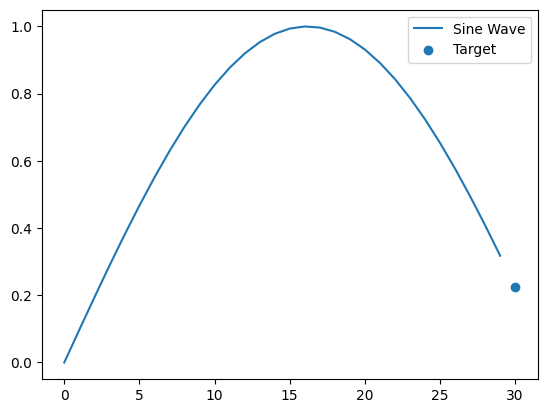

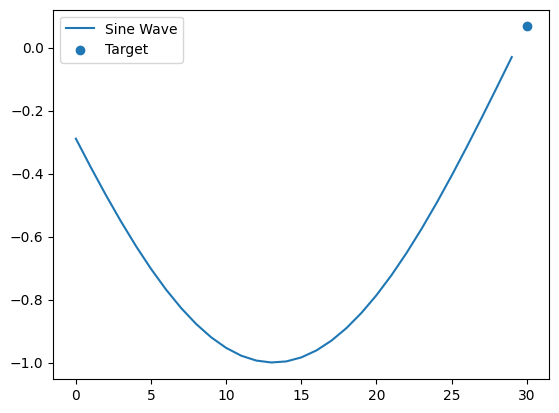

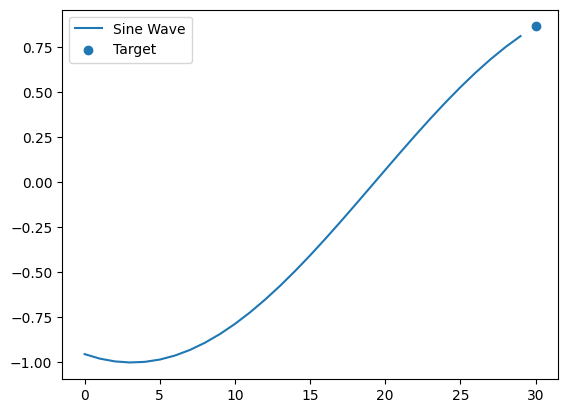

In [93]:
SEQ_LENGTH = 30
NUM_SAMPLES = 1030

X, y = generate_data(SEQ_LENGTH, NUM_SAMPLES)

for i in [0,100,110]:
  xis = np.arange(len(X[i])+1)
  # Plot the dataset
  plt.plot(xis[:-1], X[i], label='Sine Wave')
  plt.scatter(xis[-1], y[i], label='Target')
  plt.legend()
  plt.show()

# 2. Forecasting with a simple MLP

First, we will use a simple multi layer perceptron to try to predict the y values, as we always do we put the data in a dataset and split using a dataloader

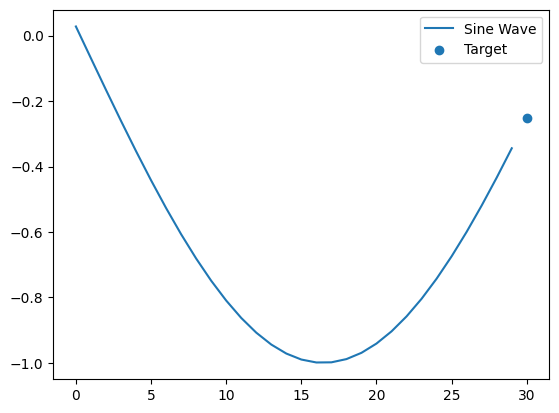

In [94]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Define a PyTorch Dataset
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create PyTorch Datasets
train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for inputs, target in train_loader:
  xis = np.arange(len(inputs[0])+1)
  plt.plot(xis[:-1], inputs[0], label='Sine Wave')
  plt.scatter(xis[-1], target[0], label='Target')
  plt.legend()
  plt.show()
  break


**Exercise** Explain what is the task, including the dimension of input and output

**Exercise** Complete the code such that it runs smoothly (replace the ...)

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the MLP model
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(30, 64),  # First layer
            nn.ReLU(),                # Activation
            nn.Linear(64, 32),        # Second layer
            nn.ReLU(),                # Activation
            nn.Linear(32, 1) # Output layer
        )

    def forward(self, x):
        return self.model(x).squeeze()

model = SimpleMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    loss_epoch = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss_epoch += loss.item()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    if epoch % 1 == 0:
        model.eval()
        loss_test = 0
        for batch_idx, (inputs, targets) in enumerate(test_loader):

          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss_test += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss train: {loss_epoch:.4f}, Loss test: {loss_test:.4f}")


Epoch [1/10], Loss train: 11.6197, Loss test: 0.0613
Epoch [2/10], Loss train: 0.3972, Loss test: 0.0133
Epoch [3/10], Loss train: 0.0653, Loss test: 0.0048
Epoch [4/10], Loss train: 0.0124, Loss test: 0.0006
Epoch [5/10], Loss train: 0.0031, Loss test: 0.0003
Epoch [6/10], Loss train: 0.0015, Loss test: 0.0002
Epoch [7/10], Loss train: 0.0011, Loss test: 0.0001
Epoch [8/10], Loss train: 0.0007, Loss test: 0.0001
Epoch [9/10], Loss train: 0.0005, Loss test: 0.0001
Epoch [10/10], Loss train: 0.0004, Loss test: 0.0000


# 2. Forecasting with an RNN

Now we will use an RNN. We propose an implementaiton of a simple RNN.

**Exercise** Explain below why the input dimension of the RNN layer is 1 ?

**Exercise** Run the follwoing and explain line a, b and c below. Use [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html):

In [99]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self,hidden_size=256,num_layers=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self, x):
        out, h = self.rnn(x) #out contains the output at each step, h is the final hidden state for each sequence
        out = self.fc(out[:, -1, :])
        return out.squeeze()

model = RNNModel()

X_temp,_ = next(iter(train_loader)) #Line a
X_temp = X_temp.unsqueeze(-1) #Line b
model(X_temp) #Line c

tensor([0.0480, 0.0483, 0.0527, 0.0491, 0.0502, 0.0549, 0.0552, 0.0531, 0.0477,
        0.0479, 0.0552, 0.0552, 0.0545, 0.0553, 0.0549, 0.0509, 0.0487, 0.0490,
        0.0552, 0.0549, 0.0552, 0.0475, 0.0551, 0.0552, 0.0481, 0.0553, 0.0547,
        0.0533, 0.0475, 0.0475, 0.0497, 0.0475], grad_fn=<SqueezeBackward0>)

# It's training time ^^

In [100]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    loss_epoch = 0
    for seq, target in train_loader:
        seq = seq.unsqueeze(-1)  # Add feature dimension
        output = model(seq)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    if epoch % 1 == 0:
        model.eval()
        loss_test = 0
        for seq, target in test_loader:
          seq = seq.unsqueeze(-1)  # Add feature dimension
          output = model(seq)
          loss = criterion(output, target)
          loss_test += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss train: {loss_epoch:.4f}, Loss test: {loss_test:.4f}")

Epoch [1/10], Loss train: 3.7127, Loss test: 0.0512
Epoch [2/10], Loss train: 0.1487, Loss test: 0.0038
Epoch [3/10], Loss train: 0.0148, Loss test: 0.0012
Epoch [4/10], Loss train: 0.0048, Loss test: 0.0010
Epoch [5/10], Loss train: 0.0028, Loss test: 0.0008
Epoch [6/10], Loss train: 0.0023, Loss test: 0.0005
Epoch [7/10], Loss train: 0.0023, Loss test: 0.0006
Epoch [8/10], Loss train: 0.0026, Loss test: 0.0004
Epoch [9/10], Loss train: 0.0018, Loss test: 0.0003
Epoch [10/10], Loss train: 0.0015, Loss test: 0.0003


# 3. Doing next time step prediciton in an autoregressive way

Now, we switch paradigme, and instead of using 30 time step to predict the 31st, we to x_{0:t} to x_{t+1}. It is easy to implement.

In [ ]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self,hidden_size=256,num_layers=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self, x):
        out, h = self.rnn(x) #out contains the output at each step, h is the final hidden state for each sequence
        out = self.fc(out[:, :-1, :])
        return out

model = RNNModel()

X_temp,_ = next(iter(train_loader)) #Line a
X_temp = X_temp.unsqueeze(-1) #Line b
model(X_temp).shape #Line c

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
NUM_EPOCHS = 50

for epoch in range(NUM_EPOCHS):
    loss_epoch = 0
    for seq, _ in train_loader:
        seq = seq.unsqueeze(-1)  # Add feature dimension
        output = model(seq)
        loss = criterion(output, seq[:,1:,:])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    if epoch % 10 == 0:
        model.eval()
        loss_test = 0
        for seq, _ in test_loader:
          seq = seq.unsqueeze(-1)  # Add feature dimension
          output = model(seq)
          loss = criterion(output, seq[:,1:,:])
          loss_test += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss train: {loss_epoch:.4f}, Loss test: {loss_test:.4f}")

Epoch [1/10], Loss train: 2.4124, Loss test: 0.1158
Epoch [11/10], Loss train: 0.0468, Loss test: 0.0101


**Exercise** Spot the differences and explain what is happening here.